# imports

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as distrib
import torch.distributions.transforms as transform
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(-4, 4, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])

Populating the interactive namespace from numpy and matplotlib


In [2]:
class Flow(transform.Transform, nn.Module):
    
    def __init__(self):
        transform.Transform.__init__(self)
        nn.Module.__init__(self)
    
    # Init all parameters
    def init_parameters(self):
        for param in self.parameters():
            param.data.uniform_(-0.01, 0.01)
            
    # Hacky hash bypass
    def __hash__(self):
        return nn.Module.__hash__(self)

In [3]:
class PlanarFlow(Flow):

    def __init__(self, dim):
        super(PlanarFlow, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(1, dim))
        self.scale = nn.Parameter(torch.Tensor(1, dim))
        self.bias = nn.Parameter(torch.Tensor(1))
        self.init_parameters()

    def _call(self, z):
        f_z = F.linear(z, self.weight, self.bias)
        return z + self.scale * torch.tanh(f_z)

    def log_abs_det_jacobian(self, z):
        f_z = F.linear(z, self.weight, self.bias)
        psi = (1 - torch.tanh(f_z) ** 2) * self.weight
        det_grad = 1 + torch.mm(psi, self.scale.t())
        return torch.log(det_grad.abs() + 1e-9)
    
class RadialFlow(Flow):

    def __init__(self, dim):
        super(RadialFlow, self).__init__()
        self.z0 = nn.Parameter(torch.Tensor(1, dim))
        self.alpha = nn.Parameter(torch.Tensor(1))
        self.beta = nn.Parameter(torch.Tensor(1))
        self.dim = dim
        self.init_parameters()

    def _call(self, z):
        r = torch.norm(z - self.z0, dim=1).unsqueeze(1)
        h = 1 / (self.alpha + r)
        return z + (self.beta * h * (z - self.z0))

    def log_abs_det_jacobian(self, z):
        r = torch.norm(z - self.z0, dim=1).unsqueeze(1)
        h = 1 / (self.alpha + r)
        hp = - 1 / (self.alpha + r) ** 2
        bh = self.beta * h
        det_grad = ((1 + bh) ** self.dim - 1) * (1 + bh + self.beta * hp * r)
        return torch.log(det_grad.abs() + 1e-9)

In [4]:
# Main class for normalizing flow
class NormalizingFlow(nn.Module):

    def __init__(self, dim, blocks, flow_length, density):
        super().__init__()
        biject = []
        for f in range(flow_length):
            for b_flow in blocks:
                biject.append(b_flow(dim))
        self.transforms = transform.ComposeTransform(biject)
        self.bijectors = nn.ModuleList(biject)
        self.base_density = density
        self.final_density = distrib.TransformedDistribution(density, self.transforms)
        self.log_det = []

    def forward(self, z):
        self.log_det = []
        # Applies series of flows
        for b in range(len(self.bijectors)):
            self.log_det.append(self.bijectors[b].log_abs_det_jacobian(z))
            z = self.bijectors[b](z)
        return z, self.log_det

In [5]:
class VAE(nn.Module):
    
    def __init__(self, encoder, decoder, encoder_dims, latent_dims):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.latent_dims = latent_dims
        self.encoder_dims = encoder_dims
        self.mu = nn.Linear(encoder_dims, latent_dims)
        self.sigma = nn.Sequential(
            nn.Linear(encoder_dims, latent_dims),
            nn.Softplus(),
            nn.Hardtanh(min_val=1e-4, max_val=5.))
        self.apply(self.init_parameters)
    
    def init_parameters(self, m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    def encode(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        sigma = self.sigma(x)
        return mu, sigma
    
    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        # Encode the inputs
        z_params = self.encode(x)
        # Obtain latent samples and latent loss
        z_tilde, kl_div = self.latent(x, z_params)
        # Decode the samples
        x_tilde = self.decode(z_tilde)
        return x_tilde, kl_div
    
    def latent(self, x, z_params):
        n_batch = x.size(0)
        # Retrieve mean and var
        mu, sigma = z_params
        # Re-parametrize
        q = distrib.Normal(torch.zeros(mu.shape[1]), torch.ones(sigma.shape[1]))
        z = (sigma * q.sample((n_batch, ))) + mu
        # Compute KL divergence
        kl_div = -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())
        kl_div = kl_div / n_batch
        return z, kl_div

In [6]:
def construct_encoder_decoder(nin, n_latent = 16, n_hidden = 512, n_classes = 1):
    # Encoder network
    encoder = nn.Sequential(
                nn.Linear(nin, n_hidden),
                nn.ReLU(True),
                nn.Linear(n_hidden, n_hidden),
                nn.ReLU(True),
                nn.Linear(n_hidden, n_hidden))
    # Decoder network
    decoder = nn.Sequential(
                nn.Linear(n_latent, n_hidden),
                nn.ReLU(True),
                nn.Linear(n_hidden, n_hidden),
                nn.ReLU(True),
                nn.Linear(n_hidden, nin * n_classes),
                nn.Sigmoid())
    return encoder, decoder

In [7]:
def binary_loss(x_tilde, x):
    return F.binary_cross_entropy(x_tilde, x, reduction='none').sum(dim = 0)

def multinomial_loss(x_logit, x):
    batch_size = x.shape[0]
    # Reshape input
    x_logit = x_logit.view(batch_size, num_classes, x.shape[1], x.shape[2], x.shape[3])
    # Take softmax
    x_logit = F.log_softmax(x_logit, 1)
    # make integer class labels
    target = (x * (num_classes - 1)).long()
    # computes cross entropy over all dimensions separately:
    ce = F.nll_loss(x_logit, target, weight=None, reduction='none')
    return ce.sum(dim = 0)*100

def reconstruction_loss(x_tilde, x, num_classes=1, average=True):
    if (num_classes == 1):
        loss = binary_loss(x_tilde, x.view(x.size(0), -1))
    else:
        loss = multinomial_loss(x_tilde, x)
    if (average):
        loss = loss.sum() / x.size(0)
    return loss

In [9]:
batch_size = 64
from torchvision import datasets
from torchvision import transforms
tens_t = transforms.ToTensor()
train_dset = datasets.MNIST('../../../../../data/', train=True, download=False, transform=tens_t)
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=batch_size, shuffle=True)
test_dset = datasets.MNIST('../../../../../data', train=False, transform=tens_t)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=batch_size, shuffle=True)


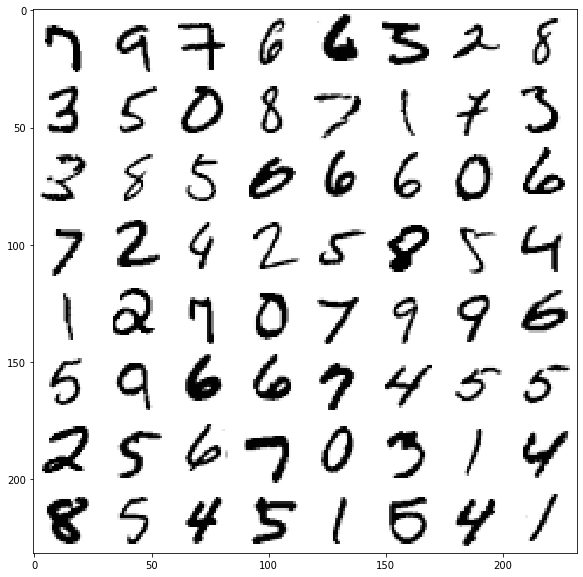

In [10]:
def plot_batch(batch, nslices=8):
    # Create one big image for plot
    img = np.zeros(((batch.shape[2] + 1) * nslices, (batch.shape[3] + 1) * nslices))
    for b in range(batch.shape[0]):
        row = int(b / nslices); col = int(b % nslices)
        r_p = row * batch.shape[2] + row; c_p = col * batch.shape[3] + col
        img[r_p:(r_p+batch.shape[2]),c_p:(c_p+batch.shape[3])] = torch.sum(batch[b], 0)
    im = plt.imshow(img, cmap='Greys', interpolation='nearest'),
    return im
# Select a random set of fixed data
fixed_batch, fixed_targets = next(iter(test_loader))
plt.figure(figsize=(10, 10))
plot_batch(fixed_batch);

In [11]:
# Using Bernoulli or Multinomial loss
num_classes = 1
# Number of hidden and latent
n_hidden = 512
n_latent = 2
# Compute input dimensionality
nin = fixed_batch.shape[2] * fixed_batch.shape[3]
# Construct encoder and decoder
encoder, decoder = construct_encoder_decoder(nin, n_hidden = n_hidden, n_latent = n_latent, n_classes = num_classes)
# Build the VAE model
model = VAE(encoder, decoder, n_hidden, n_latent)
# Create optimizer algorithm
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Add learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.99995)

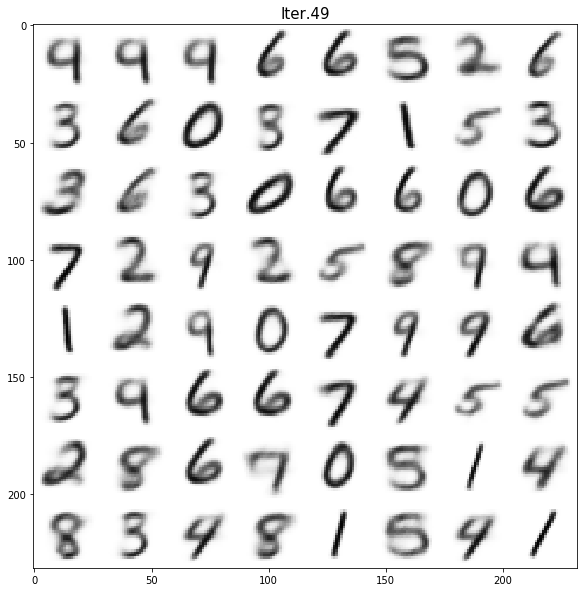

In [15]:
def train_vae(model, optimizer, scheduler, train_loader, fixed_batch, model_name='basic', epochs=50, plot_it=1, subsample=5000, flatten=True):
    # Losses curves
    losses = torch.zeros(epochs, 2)
    # Beta-warmup
    beta = 0
    # Plotting
    ims = []
    fig = plt.figure(figsize=(10, 10))
    # Main optimization loop
    for it in tqdm(range(epochs)):
        it_loss = torch.Tensor([2])
        # Update our beta
        beta = 1. * (it / float(epochs))
        n_batch = 0.
        # Evaluate loss and backprop
        for batch_idx, (x, _) in enumerate(train_loader):
            if (batch_idx * batch_size) > subsample:
                break
            # Flatten input data
            if (flatten):
                x = x.view(-1, nin)
            # Pass through VAE
            x_tilde, loss_latent = model(x)
            # Compute reconstruction loss
            loss_recons = reconstruction_loss(x_tilde, x, num_classes)
            # Evaluate loss and backprop
            loss = loss_recons + (beta * loss_latent)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            losses[it, 0] += loss_recons.item()
            losses[it, 1] += loss_latent.item()
            n_batch += 1.
        losses[it, :] /= n_batch
        if (it % plot_it == 0):
            # Encode our fixed batch
            samples = fixed_batch
            if (flatten):
                samples = fixed_batch.view(-1, nin)
            x_tilde, _ = model(samples)
            if (num_classes > 1):
                # Find largest class logit
                tmp = x_tilde.view(-1, num_classes, *x[0].shape[1:]).max(dim=1)[1]
                x_tilde = tmp.float() / (num_classes - 1.)
            ims.append(plot_batch(x_tilde.detach().view_as(fixed_batch)))
            plt.title('Iter.%i'%(it), fontsize=15);
    # Generate our animation
#     anim = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
#     HTML(anim.to_html5_video())
#     anim.save("vae_" + model_name + ".mp4")
    return losses
            
# Launch our optimization
losses_kld = train_vae(model, optimizer, scheduler, train_loader, fixed_batch, model_name='basic', epochs=50)

In [17]:
from scipy.special import logsumexp

def evaluate_nll_bpd(data_loader, model, batch = 500, R = 5):
    model.eval()
    # Set of likelihood tests
    likelihood_test = []
    # Go through dataset
    for batch_idx, (x, _) in enumerate(data_loader):
        for j in range(x.shape[0]):
            a = []
            for r in range(0, R):
                cur_x = x[j].unsqueeze(0)
                # Repeat it as batch
                x = cur_x.expand(batch, *cur_x.size()[1:]).contiguous()
                x = x.view(batch, -1)
                x_tilde, kl_div = model(x)
                rec = reconstruction_loss(x_tilde, x, average=False)
                a_tmp = (rec + kl_div)
                a.append(- a_tmp.cpu().data.numpy())
            # calculate max
            a = np.asarray(a)
            a = np.reshape(a, (a.shape[0] * a.shape[1], 1))
            likelihood_x = logsumexp(a)
            likelihood_test.append(likelihood_x - np.log(len(a)))
    likelihood_test = np.array(likelihood_test)
    nll = - np.mean(likelihood_test)
    # Compute the bits per dim (but irrelevant for binary data)
    bpd = nll / (np.prod(nin) * np.log(2.))
    return nll, bpd


Negative Log-Likelihood : 1.1798906288542255


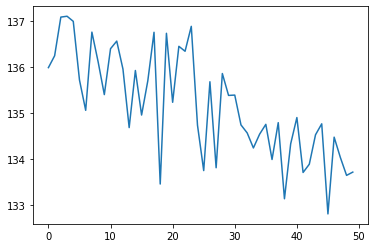

In [18]:
# Plot final loss
plt.figure()
plt.plot(losses_kld[:, 0].numpy());
# Evaluate log-likelihood and bits per dim
nll, _ = evaluate_nll_bpd(test_loader, model)
print('Negative Log-Likelihood : ' + str(nll))


In [19]:
class VAENormalizingFlow(VAE):
    
    def __init__(self, encoder, decoder, flow, encoder_dims, latent_dims):
        super(VAENormalizingFlow, self).__init__(encoder, decoder, encoder_dims, latent_dims)
        self.flow = flow

    def latent(self, x, z_params):
        n_batch = x.size(0)
        # Retrieve set of parameters
        mu, sigma = z_params
        # Re-parametrize a Normal distribution
        q = distrib.Normal(torch.zeros(mu.shape[1]), torch.ones(sigma.shape[1]))
        # Obtain our first set of latent points
        z_0 = (sigma * q.sample((n_batch, ))) + mu
        # Complexify posterior with flows
        z_k, list_ladj = self.flow(z_0)
        # ln p(z_k) 
        log_p_zk = -0.5 * z_k * z_k
        # ln q(z_0)
        log_q_z0 = -0.5 * (sigma.log() + (z_0 - mu) * (z_0 - mu) * sigma.reciprocal())
        #  ln q(z_0) - ln p(z_k)
        logs = (log_q_z0 - log_p_zk).sum()
        # Add log determinants
        ladj = torch.cat(list_ladj)
        # ln q(z_0) - ln p(z_k) - sum[log det]
        logs -= torch.sum(ladj)
        return z_k, (logs / float(n_batch))

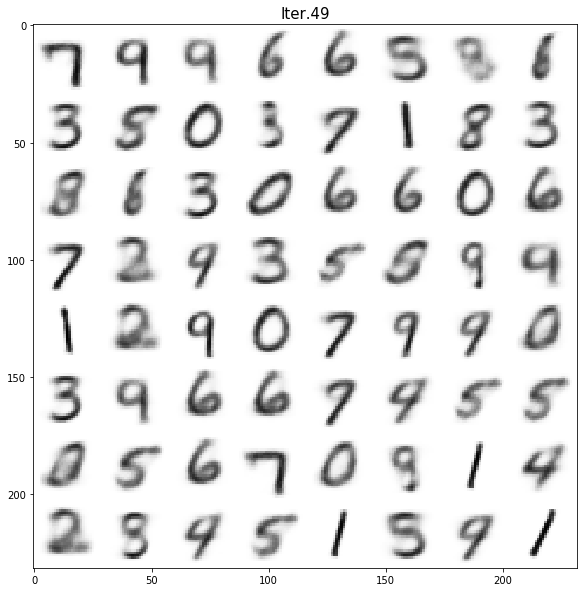

In [20]:
# Using Bernoulli or Multinomial loss
num_classes = 1
# Number of hidden and latent
n_hidden = 512
n_latent = 2
# Our MLP blocks
block_planar = [PlanarFlow]
# Create normalizing flow
flow = NormalizingFlow(dim=n_latent, blocks=block_planar, flow_length=16, density=distrib.MultivariateNormal(torch.zeros(n_latent), torch.eye(n_latent)))
# Construct encoder and decoder
encoder, decoder = construct_encoder_decoder(nin, n_hidden = n_hidden, n_latent = n_latent, n_classes = num_classes)
# Create VAE with planar flows
model_flow = VAENormalizingFlow(encoder, decoder, flow, n_hidden, n_latent)
# Create optimizer algorithm
optimizer = optim.Adam(model_flow.parameters(), lr=1e-3)
# Add learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.99995)
# Launch our optimization
losses_flow = train_vae(model_flow, optimizer, scheduler, train_loader, fixed_batch, model_name='flow', epochs=50)

Negative Log-Likelihood : 5.086576994840096


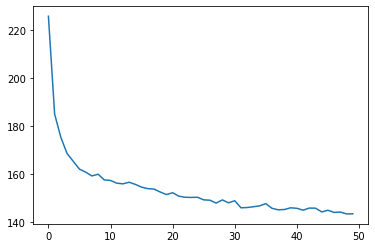

In [21]:
# Plot losses
plt.figure()
plt.plot(losses_flow[:, 0].numpy());
# Evaluate log-likelihood and bits per dim
nll, _ = evaluate_nll_bpd(test_loader, model_flow)
print('Negative Log-Likelihood : ' + str(nll))

In [22]:
# Main class for normalizing flow
class NormalizingFlow(nn.Module):

    def __init__(self, dim, blocks, flow_length, density):
        super().__init__()
        biject = []
        self.n_params = []
        for f in range(flow_length):
            for b_flow in blocks:
                cur_block = b_flow(dim)
                biject.append(cur_block)
                self.n_params.append(cur_block.n_parameters())
        self.transforms = transform.ComposeTransform(biject)
        self.bijectors = nn.ModuleList(biject)
        self.base_density = density
        self.final_density = distrib.TransformedDistribution(density, self.transforms)
        self.log_det = []
        self.dim = dim

    def forward(self, z):
        self.log_det = []
        # Applies series of flows
        for b in range(len(self.bijectors)):
            self.log_det.append(self.bijectors[b].log_abs_det_jacobian(z))
            z = self.bijectors[b](z)
        return z, self.log_det
        
    def n_parameters(self):
        return sum(self.n_params)
    
    def set_parameters(self, params):
        param_list = params.split(self.n_params, dim = 1)
        # Applies series of flows
        for b in range(len(self.bijectors)):
            self.bijectors[b].set_parameters(param_list[b])


In [23]:
class PlanarFlow(Flow):

    def __init__(self, dim):
        super(PlanarFlow, self).__init__()
        self.weight = []
        self.scale = []
        self.bias = []
        self.dim = dim

    def _call(self, z):
        z = z.unsqueeze(2)
        f_z = torch.bmm(self.weight, z) + self.bias
        return (z + self.scale * torch.tanh(f_z)).squeeze(2)

    def log_abs_det_jacobian(self, z):
        z = z.unsqueeze(2)
        f_z = torch.bmm(self.weight, z) + self.bias
        psi = self.weight * (1 - torch.tanh(f_z) ** 2)
        det_grad = 1 + torch.bmm(psi, self.scale)
        return torch.log(det_grad.abs() + 1e-9)
    
    def set_parameters(self, p_list):
        self.weight = p_list[:, :self.dim].unsqueeze(1)
        self.scale = p_list[:, self.dim:self.dim*2].unsqueeze(2)
        self.bias = p_list[:, self.dim*2].unsqueeze(1).unsqueeze(2)
        
    def n_parameters(self):
        return 2 * self.dim + 1

In [24]:
class VAENormalizingFlow(VAE):
    
    def __init__(self, encoder, decoder, flow, encoder_dims, latent_dims):
        super(VAENormalizingFlow, self).__init__(encoder, decoder, encoder_dims, latent_dims)
        self.flow_enc = nn.Linear(encoder_dims, flow.n_parameters())
        self.flow = flow
        self.apply(self.init_parameters)
        self.flow_enc.weight.data.uniform_(-0.01, 0.01)
            
    def encode(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        sigma = self.sigma(x)
        flow_params = self.flow_enc(x)
        return mu, sigma, flow_params

    def latent(self, x, z_params):
        n_batch = x.size(0)
        # Split the encoded values to retrieve flow parameters
        mu, sigma, flow_params = z_params
        # Re-parametrize a Normal distribution
        q = distrib.Normal(torch.zeros(mu.shape[1]), torch.ones(sigma.shape[1]))
        # Obtain our first set of latent points
        z_0 = (sigma * q.sample((n_batch, ))) + mu
        # Update flows parameters
        self.flow.set_parameters(flow_params)
        # Complexify posterior with flows
        z_k, list_ladj = self.flow(z_0)
        # ln p(z_k) 
        log_p_zk = -0.5 * z_k * z_k
        # ln q(z_0)
        log_q_z0 = -0.5 * (sigma.log() + (z_0 - mu) * (z_0 - mu) * sigma.reciprocal())
        #  ln q(z_0) - ln p(z_k)
        logs = (log_q_z0 - log_p_zk).sum()
        # Add log determinants
        ladj = torch.cat(list_ladj)
        # ln q(z_0) - ln p(z_k) - sum[log det]
        logs -= torch.sum(ladj)
        return z_k, (logs / float(n_batch))

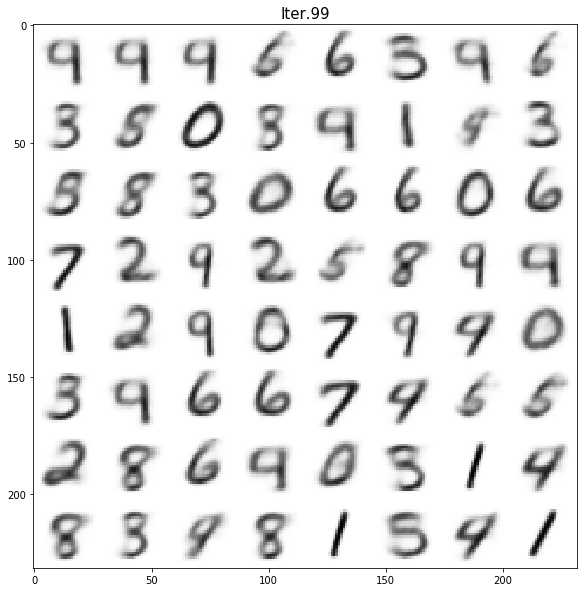

In [25]:
# Using Bernoulli or Multinomial loss
num_classes = 1
# Number of hidden and latent
n_hidden = 512
n_latent = 2
# Our MLP blocks
block_planar = [PlanarFlow]
# Create normalizing flow
flow = NormalizingFlow(dim=n_latent, blocks=block_planar, flow_length=16, density=distrib.MultivariateNormal(torch.zeros(n_latent), torch.eye(n_latent)))
# Construct encoder and decoder
encoder, decoder = construct_encoder_decoder(nin, n_hidden = n_hidden, n_latent = n_latent, n_classes = num_classes)
# Create VAE with planar flows
model_flow_p = VAENormalizingFlow(encoder, decoder, flow, n_hidden, n_latent)
# Create optimizer algorithm
optimizer = optim.Adam(model_flow_p.parameters(), lr=1e-3)
# Add learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)
# Launch our optimization
losses_flow_param = train_vae(model_flow_p, optimizer, scheduler, train_loader, fixed_batch, model_name='flow_params', epochs=100)